In [ ]:
%matplotlib inline
from sqlalchemy import create_engine
from sqlalchemy.sql import text
import os
import pandas as pd
import numpy as np
import geopandas as gpd
from scipy.integrate import odeint
import seaborn as sns
from pysal.lib import weights
from pysal.explore import esda
from splot.esda import moran_scatterplot, lisa_cluster, plot_local_autocorrelation
import contextily as ctx
import matplotlib.pyplot as plt
np.random.seed(1)

# Functions

In [ ]:
## Function of SEIR model.
## Function that takes in the above, maps out the figures appropriately.
## It's unclear if this is the actual best model or something alot more sophisticated is used.

def seir(y, t, n, alpha, beta, gamma):
    """
    y = initial vector of susceptible, infected, exposed, and removed/recovered
    t = time in days
    n = the population
    alpha = incubation period
    beta = effected contact rate - you would consider this the r0
    gamma = infectious period - imperial is 4.6
    
    This will return s, e, i, r so assign the return lists to variables of the same name.
    """
    def df_e(y, t, n, alpha, beta, gamma):
        ## Once we know where the first cases in Warwickshire were.
        ## Can tailor the contact rate. for instance
#         t > 16:
#             beta = 0.62 
        s, e, i, r = y
        dS_dt = -beta * s * i / n
        dE_dt = beta * s * i / n - alpha * e
        dI_dt = alpha * e - gamma * i
        dR_dt = gamma * i
        return dS_dt, dE_dt, dI_dt, dR_dt
    ret = odeint(df_e, y, t, args=(n, alpha, beta, gamma))
    return ret.T

def seir_timeseries_and_summed(df, geography_column_name, f_index, l_index):
    """
    The df is assumed to be a typical index. If using a groupby, you'll need to reset index.
    
    Take a df and the geography code to work from and output, a dictionary of time series.
    The return will be seir_dfs which is a dictionary of the geography code, the age groups
    and then a dataframe of the time series.
    
    It will return a second value, which is a summarised dataframe of the first.
    
    df : Takes the specified df, assumes the column is 0 for the geography.
    
    
    f_index : First position of age group.
    l_index : The last position remembering that list exclude last position, so upto
    """
    # Create nested dictionary, with the dataframes of each group added with the time series data.
    seir_dfs = {}
    for code in df.iloc[:, 0]:
        seir_dfs[code] = {df.columns[f_index+x]: pd.DataFrame() for x in range(len(df.columns[f_index:l_index]))}   

    ## Working on summing
    seir_summed_df = pd.DataFrame({geography_column_name: df.iloc[:, 0]})
    ## This could be added into the for loop below. However, the code is already not great to read
    ## The key difference is seir_dfs, creates the time series, as dataframes solely of time
    ## Where as seir_summed_df creates a single table of summed figures matching to lsoa.
    for x in range(len(df.columns[f_index:l_index])):
        seir_summed_df[df.columns[f_index+x] + '_scrh_imperial_2.4_sum'] = np.arange(len(df.iloc[:, 0]))
        seir_summed_df[df.columns[f_index+x] + '_hcrcc_imperial_2.4_sum'] = np.arange(len(df.iloc[:, 0]))
        seir_summed_df[df.columns[f_index+x] + '_ifr_imperial_2.4_sum'] = np.arange(len(df.iloc[:, 0]))
        seir_summed_df[df.columns[f_index+x] + '_scrh_cmmid_0.62_sum'] = np.arange(len(df.iloc[:, 0]))
        seir_summed_df[df.columns[f_index+x] + '_hcrcc_cmmid_0.62_sum'] = np.arange(len(df.iloc[:, 0]))
        seir_summed_df[df.columns[f_index+x] + '_ifr_cmmid_0.62_sum'] = np.arange(len(df.iloc[:, 0]))


    for _ in range(len(df.columns[f_index:l_index])):
        for row in range(len(df.iloc[:,f_index + _])):
            ## n in this instance is the sample/population and not a throwaway variable!
            n = df.iloc[row, f_index+_]
            #initial infection
            i_0 = 1
            # exposed and removed
            e_0 = 1
            r_0 = 0
            # susceptible to infection initially
            s_0 = n - i_0 - e_0 - r_0
            y_0 = s_0, e_0, i_0, r_0
            #alpha = incubation - imperial is 5.1
            alpha = 1./5.1
            # beta effected contact rate - imperial is 2.4
            beta = 2.4
            # gamma infectious period - imperial is 4.6
            gamma = 1./4.6
            # time (in days)
            t = np.linspace(0, 200, 200)
            ## get the value of row n from column i - n is the population these will return lists
            ## note the spread of how this looks.
            s, e, i, r = seir(y_0, t, n, alpha, beta, gamma)
            seir_dfs[df.iloc[row, 0]][df.columns[f_index+_]][df.columns[f_index+_] + '_s_imperial_2.4'] = s
            seir_dfs[df.iloc[row, 0]][df.columns[f_index+_]][df.columns[f_index+_] + '_e_imperial_2.4'] = e
            seir_dfs[df.iloc[row, 0]][df.columns[f_index+_]][df.columns[f_index+_] + '_i_imperial_2.4'] = i
            seir_dfs[df.iloc[row, 0]][df.columns[f_index+_]][df.columns[f_index+_] + '_r_imperial_2.4'] = r
            ## Bring in age_params_df now
            ## cases symptomatic is assumed .66
            cs = age_params_df.iloc[_, 1]
            # symptomatic cases requiring hospitalisation
            scrh = i * cs * age_params_df.iloc[_, 2]
            seir_dfs[df.iloc[row, 0]][df.columns[f_index+_]][df.columns[f_index+_] + '_scrh_imperial_2.4'] = scrh
            # hospitalised cases requiring critical care
            hcrcc = scrh * age_params_df.iloc[_, 3]
            seir_dfs[df.iloc[row, 0]][df.columns[f_index+_]][df.columns[f_index+_] + '_hcrcc_imperial_2.4'] = hcrcc
            # infection fatality ratio from hcrrc only
            ifr = hcrcc * age_params_df.iloc[_, 4]
            seir_dfs[df.iloc[row, 0]][df.columns[f_index+_]][df.columns[f_index+_] + '_ifr_imperial_2.4'] = ifr

            # add to the summed df
            seir_summed_df.loc[row, df.columns[f_index+_] + '_scrh_imperial_2.4_sum'] = scrh.sum()
            seir_summed_df.loc[row, df.columns[f_index+_] + '_hcrcc_imperial_2.4_sum'] = hcrcc.sum()
            seir_summed_df.loc[row, df.columns[f_index+_] + '_ifr_imperial_2.4_sum'] = ifr.sum()

            ## Add the Centre for Mathematical Modelling of Infectious disease paper
            ## "Impact of physical distance measures on transmission in the UK"
            i_1 = 1
            # exposed and removed
            e_1 = 1
            r_1 = 0
            # susceptible to infection initially
            s_1 = n - i_1 - e_1 - r_1
            y_1 = s_1, e_1, i_1, r_1
            #alpha = incubation - imperial is 5.1
            alpha = 1./5.1
            # beta effected contact rate - imperial is 2.4
            beta = 0.62
            # gamma infectious period - imperial is 4.6
            gamma = 1./4.6
            # time (in days)
            t = np.linspace(0, 200, 200)
            ## get the value of row n from column _ - n is the population these will return lists
            ## note the spread of how this looks.
            s, e, i, r = seir(y_1, t, n, alpha, beta, gamma)
            seir_dfs[df.iloc[row, 0]][df.columns[f_index+_]][df.columns[f_index+_] + '_s_cmmid_0.62'] = s
            seir_dfs[df.iloc[row, 0]][df.columns[f_index+_]][df.columns[f_index+_] + '_e_cmmid_0.62'] = e
            seir_dfs[df.iloc[row, 0]][df.columns[f_index+_]][df.columns[f_index+_] + '_i_cmmid_0.62'] = i
            seir_dfs[df.iloc[row, 0]][df.columns[f_index+_]][df.columns[f_index+_] + '_r_cmmid_0.62'] = r
            ## Bring in age_params_df now
            ## cases symptomatic is assumed .66
            cs = age_params_df.iloc[_, 1]
            # symptomatic cases requiring hospitalisation
            scrh = i * cs * age_params_df.iloc[_, 2]
            seir_dfs[df.iloc[row, 0]][df.columns[f_index+_]][df.columns[f_index+_] + '_scrh_cmmid_0.62'] = scrh
            # hospitalised cases requiring critical care
            hcrcc = scrh * age_params_df.iloc[_, 3]
            seir_dfs[df.iloc[row, 0]][df.columns[f_index+_]][df.columns[f_index+_] + '_hcrcc_cmmid_0.62'] = hcrcc
            # infection fatality ratio from hcrrc only
            ifr = hcrcc * age_params_df.iloc[_, 4]
            seir_dfs[df.iloc[row, 0]][df.columns[f_index+_]][df.columns[f_index+_] + '_ifr_cmmid_0.62'] = ifr

            #add to the summed df
            seir_summed_df.loc[row, df.columns[f_index+_] + '_scrh_cmmid_0.62_sum'] = scrh.sum()
            seir_summed_df.loc[row, df.columns[f_index+_] + '_hcrcc_cmmid_0.62_sum'] = hcrcc.sum()
            seir_summed_df.loc[row, df.columns[f_index+_] + '_ifr_cmmid_0.62_sum'] = ifr.sum()

    return seir_dfs, seir_summed_df

In [ ]:
## Age, symptomatic, hospitalisation, critical, and Infection Fatality Ratio
age_params_df = pd.read_excel('data/parameters_age.xlsx')
age_params_df.head(10)

In [ ]:
# Connect to the POSTGIS Database
user = os.environ['WCC_USER'].lower()
pw = os.environ['POSTGIS_PW']
postgis = os.environ['POSTGIS_DB_REST_OF_CONN']
# connection string
engine = create_engine('postgresql://' + user +  ':' + pw + postgis,
                      connect_args={'sslmode':'require'})
conn = engine.connect()
q = """
SELECT lsoa.code AS lsoa_code,
lsoa.name AS lsoa_name,
wcc_local.local_name AS lsoa_local_name,
lsoa.area AS lsoa_area,
lsoa.lengths AS lsoa_lengths,
lsoa.geom AS lsoa_geom,
-- add EPSG426
ST_Transform(lsoa.geom, 4326) AS lsoa_long_lat_geom,
ST_ASText(ST_Transform(lsoa.geom, 4326)) AS lsoa_long_lat_text,
ccg.ccg_id,
ccg.ccg_name,
--note spelling error in column below
ccg.cch_hq_location AS ccg_hq_location,
ccg.geom AS ccg_geom,
ST_Transform(ccg.geom, 4326) AS ccg_long_lat_geom,
ST_ASText(ST_Transform(ccg.geom, 4326)) AS ccg_long_lat_text,
district_borough.district_borough_name,
district_borough.district_borough_code,
district_borough.geom AS district_borough_geom,
ST_Transform(district_borough.geom, 4326) AS district_borough_long_lat_geom,
ST_ASText(ST_Transform(district_borough.geom, 4326)) AS district_borough_long_lat_text,
jsna.jsna_id,
jsna.jsna_name,
--exclude jsna_pop_2017 latest figures will be built from mid-year 2018
jsna.geom AS jsna_geom,
ST_Transform(jsna.geom, 4326) AS jsna_long_lat_geom,
ST_ASText(ST_Transform(jsna.geom, 4326)) AS jsna_long_lat_text,
msoa.msoa_code,
msoa.msoa_name,
msoa.geom AS msoa_geom,
ST_Transform(msoa.geom, 4326) AS msoa_long_lat_geom,
ST_ASText(ST_Transform(msoa.geom, 4326)) AS msoa_long_lat_text,
ward.code AS ward_code,
ward.name AS ward_name,
ward.geom AS ward_geom,
ST_Transform(ward.geom, 4326) AS ward_long_lat_geom,
ST_ASText(ST_Transform(ward.geom, 4326)) AS ward_long_lat_text
FROM admin_boundaries.lsoa_boundaries_great_britain_polygon lsoa
LEFT JOIN admin_boundaries.ccg_areas_warwickshire_coventry_polygon ccg
ON ST_Contains(ccg.geom, ST_Centroid(lsoa.geom))
LEFT JOIN admin_boundaries.lsoa_boundaries_warwickshire_polygon wcc_local
ON lsoa.code = wcc_local.code
LEFT JOIN admin_boundaries.districts_boroughs_boundaries_warwickshire_polygon district_borough
ON ST_Contains(district_borough.geom, ST_Centroid(wcc_local.geom))
LEFT JOIN admin_boundaries.jsna_warwickshire_polygon jsna
ON ST_Contains(jsna.geom, ST_Centroid(wcc_local.geom))
LEFT JOIN admin_boundaries.msoa_boundaries_warwickshire_polygon msoa
ON ST_Contains(msoa.geom, ST_Centroid(wcc_local.geom))
LEFT JOIN admin_boundaries.ward_boundaries_great_britain_polygon ward
ON ST_Contains(ward.geom, ST_Centroid(lsoa.geom))
WHERE ST_Contains(ccg.geom, ST_Centroid(lsoa.geom))
"""

polygon_df = pd.read_sql(q, conn)

In [ ]:
polygon_df.head()

In [ ]:
oa_df = gpd.read_file('data/oa_shapefile/Output_Areas_December_2011_Boundaries_EW_BFE.shp')
oa_df.head()

In [ ]:
## Read in excel file with OA
ages_df = pd.read_excel('data/SAPE21DT10e-mid-2018-coa-unformatted-syoa-estimates-west-midlands.xlsx',
                            sheet_name='Mid-2018 Persons',
                           skiprows=4)
ages_df.head()

In [ ]:
# Transformations

In [ ]:
# create the new aggregated ages datasets.
x = 0
y = 10
new_data = {}
for i in range(9):
    l = [x for x in range(x, y)]
    new_data[f'{x}-{(y-1)}'] = ages_df[l].sum(axis=1)
    x += 10
    y += 10

#add in the 90+ category to the 80+
new_data['80+'] = new_data['80-89'] + ages_df['90+']
age_groups_df = pd.DataFrame(new_data)
#can now drop 80-89 since 80+ is created.
age_groups_df.drop('80-89', axis=1, inplace=True)
age_groups_df.head()

In [ ]:
ages_df = ages_df.merge(age_groups_df, left_index=True, right_index=True)
ages_df.head()

In [ ]:
column_drop_list = [x for x in range(90)]
column_drop_list += ['90+']
# print(column_drop_list)
ages_df = ages_df.drop(columns=column_drop_list)
ages_df.head()

In [ ]:
df = ages_df.merge(oa_df, how='left', left_on='OA11CD', right_on='OA11CD')
df = polygon_df.merge(df, how='left', left_on='lsoa_code', right_on='LSOA11CD')
## Drop columns and rename some
df = df.drop(columns=['LSOA11CD', 'FID'])
df = df.rename(columns={"LAD11CD": "local_authority_code",
                   "Shape__Are": "oa_area",
                   "Shape__Len": "oa_length",
                   "geometry": "oa_long_lat_text",
                   "OA11CD": "oa_code",
                       "All Ages": 'all_ages'})
## Reorder the columns, so the other code reads from the same area.
df = df[['oa_code',
         'oa_long_lat_text',
         'local_authority_code',
         'lsoa_code',
         'lsoa_name',
         'lsoa_local_name',
         'lsoa_area',
         'lsoa_lengths',
         'lsoa_geom',
         'lsoa_long_lat_geom',
         'lsoa_long_lat_text',
         'ccg_id',
         'ccg_name',
         'ccg_hq_location',
         'ccg_geom',
         'ccg_long_lat_geom',
         'ccg_long_lat_text',
         'district_borough_name',
         'district_borough_code',
         'district_borough_geom',
         'district_borough_long_lat_geom',
         'district_borough_long_lat_text',
         'jsna_id',
         'jsna_name',
         'jsna_geom',
         'jsna_long_lat_geom',
         'jsna_long_lat_text',
         'msoa_code',
         'msoa_name',
         'msoa_geom',
         'msoa_long_lat_geom',
         'msoa_long_lat_text',
         'ward_code',
         'ward_name',
         'ward_geom',
         'ward_long_lat_geom',
         'ward_long_lat_text',
         'all_ages',
         '0-9',
         '10-19',
         '20-29',
         '30-39',
         '40-49',
         '50-59',
         '60-69',
         '70-79',
         '80+',
         'oa_area',
         'oa_length'
        ]]
df.info()

In [ ]:
# sense check

# figure for ccg should come out to 2832
print(df['ccg_name'].value_counts(dropna=True).sum())
# figure should be 2832
print(df['lsoa_name'].value_counts(dropna=True).sum())
# local_authority_code is not inclusive of Warwickshire County Council - figure should be 2832
print(df['local_authority_code'].value_counts(dropna=True).sum())
# 2832
print(df['ward_name'].value_counts(dropna=True).sum())
# figures should be 1818
print(df['msoa_name'].value_counts(dropna=True).sum())
print(df['jsna_name'].value_counts(dropna=True).sum())

# OA

In [14]:
oa_seir_dfs, oa_seir_summed_df = seir_timeseries_and_summed(df, 'oa_code', 38, 47)

/home/tfos1/covid19/venv/lib/python3.6/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [15]:
drop_columns = ['lsoa_area', 'lsoa_lengths', 'oa_area', 'oa_length']

# Perform Groupby operations to match at (data is already at OA level):
    * LSOA
    * MSOA
    * Ward
    * District/Borough and City
    * CCG
    * Warwickshire only

# LSOA

In [16]:
grouped_lsoa_df = df.groupby(['lsoa_code']).sum()
grouped_lsoa_df = grouped_lsoa_df.drop(columns=drop_columns)
grouped_lsoa_df.reset_index(inplace=True)
grouped_lsoa_df.head()

,lsoa_code,all_ages,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80+
0,E01009522,1464,209,176,173,159,164,165,157,185,76
1,E01009523,1504,107,132,153,105,185,245,178,259,140
2,E01009524,1705,180,217,205,187,210,233,217,150,106
3,E01009525,1486,152,166,158,205,173,211,185,127,109
4,E01009526,1611,200,173,177,201,202,210,171,182,95


In [17]:
grouped_lsoa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   lsoa_code  534 non-null    object
 1   all_ages   534 non-null    int64 
 2   0-9        534 non-null    int64 
 3   10-19      534 non-null    int64 
 4   20-29      534 non-null    int64 
 5   30-39      534 non-null    int64 
 6   40-49      534 non-null    int64 
 7   50-59      534 non-null    int64 
 8   60-69      534 non-null    int64 
 9   70-79      534 non-null    int64 
 10  80+        534 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 46.0+ KB


# MSOA

In [18]:
grouped_msoa_df = df.groupby(['msoa_code']).sum()
grouped_msoa_df = grouped_msoa_df.drop(columns=drop_columns)
grouped_msoa_df.reset_index(inplace=True)
grouped_msoa_df.head()

,msoa_code,all_ages,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80+
0,E02006468,10794,1122,1232,1084,1161,1483,1605,1347,1193,567
1,E02006469,9154,1110,1087,1009,1186,1158,1378,1033,772,421
2,E02006470,11968,1444,1264,1443,1378,1496,1677,1420,1143,703
3,E02006471,6963,609,660,672,696,891,1155,1078,870,332
4,E02006472,9415,1057,1029,996,1063,1270,1483,1146,909,462


In [19]:
grouped_msoa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   msoa_code  66 non-null     object
 1   all_ages   66 non-null     int64 
 2   0-9        66 non-null     int64 
 3   10-19      66 non-null     int64 
 4   20-29      66 non-null     int64 
 5   30-39      66 non-null     int64 
 6   40-49      66 non-null     int64 
 7   50-59      66 non-null     int64 
 8   60-69      66 non-null     int64 
 9   70-79      66 non-null     int64 
 10  80+        66 non-null     int64 
dtypes: int64(10), object(1)
memory usage: 5.8+ KB


## Ward

In [20]:
grouped_ward_df = df.groupby(['ward_code']).sum()
grouped_ward_df = grouped_ward_df.drop(columns=drop_columns)
grouped_ward_df.reset_index(inplace=True)
grouped_ward_df.head()

,ward_code,all_ages,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80+
0,E05001218,17683,2112,1958,2171,2181,2252,2366,1883,1744,1016
1,E05001219,17704,2431,1996,2467,2568,1955,2214,1720,1446,907
2,E05001220,18377,2375,1635,2935,3166,2145,2024,1652,1393,1052
3,E05001221,15467,1422,1618,2530,1762,1988,2080,1782,1374,911
4,E05001222,25259,4719,3457,5006,4599,3032,1957,1270,765,454


In [21]:
grouped_ward_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124 entries, 0 to 123
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ward_code  124 non-null    object
 1   all_ages   124 non-null    int64 
 2   0-9        124 non-null    int64 
 3   10-19      124 non-null    int64 
 4   20-29      124 non-null    int64 
 5   30-39      124 non-null    int64 
 6   40-49      124 non-null    int64 
 7   50-59      124 non-null    int64 
 8   60-69      124 non-null    int64 
 9   70-79      124 non-null    int64 
 10  80+        124 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 10.8+ KB


## District, Borough and City

In [22]:
grouped_district_df = df.groupby(['local_authority_code']).sum()
grouped_district_df = grouped_district_df.drop(columns=drop_columns)
grouped_district_df.reset_index(inplace=True)
# will return 6 in the data as coventry included!
grouped_district_df.head(6)

,local_authority_code,all_ages,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80+
0,E07000218,64850,7065,6823,6986,7311,8457,9962,8115,6581,3550
1,E07000219,128902,16251,14327,15095,16731,16378,17973,14548,11484,6115
2,E07000220,107194,13572,12631,11189,14407,14677,14777,10852,9485,5604
3,E07000221,127580,12893,13387,11863,12918,16287,19576,16551,14986,9119
4,E07000222,142484,15545,15525,23901,16662,18339,18495,14412,11905,7700
5,E08000026,366785,47239,44284,78477,52882,40565,38290,28549,22413,14086


In [23]:
grouped_district_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   local_authority_code  6 non-null      object
 1   all_ages              6 non-null      int64 
 2   0-9                   6 non-null      int64 
 3   10-19                 6 non-null      int64 
 4   20-29                 6 non-null      int64 
 5   30-39                 6 non-null      int64 
 6   40-49                 6 non-null      int64 
 7   50-59                 6 non-null      int64 
 8   60-69                 6 non-null      int64 
 9   70-79                 6 non-null      int64 
 10  80+                   6 non-null      int64 
dtypes: int64(10), object(1)
memory usage: 656.0+ bytes


# Coventry and Warwickshire CCGs

In [24]:
grouped_ccg_df = df.groupby(['ccg_name']).sum()
grouped_ccg_df = grouped_ccg_df.drop(columns=drop_columns)
grouped_ccg_df.reset_index(inplace=True)
grouped_ccg_df.head()

,ccg_name,all_ages,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80+
0,Coventry & Rugby,473979,60811,56915,89666,67289,55242,53067,39401,31898,19690
1,South Warwickshire,270064,28438,28912,35764,29580,34626,38071,30963,26891,16819
2,Warwickshire North,193752,23316,21150,22081,24042,24835,27935,22663,18065,9665


In [25]:
grouped_ccg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ccg_name  3 non-null      object
 1   all_ages  3 non-null      int64 
 2   0-9       3 non-null      int64 
 3   10-19     3 non-null      int64 
 4   20-29     3 non-null      int64 
 5   30-39     3 non-null      int64 
 6   40-49     3 non-null      int64 
 7   50-59     3 non-null      int64 
 8   60-69     3 non-null      int64 
 9   70-79     3 non-null      int64 
 10  80+       3 non-null      int64 
dtypes: int64(10), object(1)
memory usage: 392.0+ bytes


# Warwickshire only

In [26]:
grouped_wcc_df = df.groupby(['district_borough_name']).sum()
grouped_wcc_df = grouped_wcc_df.drop(columns=drop_columns)
grouped_wcc_df.reset_index(inplace=True)
# This creates a series.
grouped_wcc_df = pd.DataFrame(grouped_wcc_df.sum()).transpose()
grouped_wcc_df = grouped_wcc_df.rename(columns={'district_borough_name': 'County'})
grouped_wcc_df['County'] = "Warwickshire"
grouped_wcc_df.head()

,County,all_ages,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80+
0,Warwickshire,571010,65326,62693,69034,68029,74138,80783,64478,54441,32088


In [27]:
grouped_wcc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   County    1 non-null      object
 1   all_ages  1 non-null      object
 2   0-9       1 non-null      object
 3   10-19     1 non-null      object
 4   20-29     1 non-null      object
 5   30-39     1 non-null      object
 6   40-49     1 non-null      object
 7   50-59     1 non-null      object
 8   60-69     1 non-null      object
 9   70-79     1 non-null      object
 10  80+       1 non-null      object
dtypes: object(11)
memory usage: 216.0+ bytes


In [28]:
oa_seir_dfs, oa_seir_summed_df = seir_timeseries_and_summed(df, 'oa_code', 38, 47)
lsoa_seir_dfs, lsoa_seir_summed_df = seir_timeseries_and_summed(grouped_lsoa_df, 'lsoa_code', 2, 11)
msoa_seir_dfs, msoa_seir_summed_df = seir_timeseries_and_summed(grouped_msoa_df, 'msoa_code', 2, 11)
ward_seir_dfs, ward_seir_summed_df = seir_timeseries_and_summed(grouped_ward_df, 'ward_code', 2, 11)
district_seir_dfs, district_seir_summed_df = seir_timeseries_and_summed(grouped_district_df, 'local_authority_code', 2, 11)
ccg_seir_dfs, ccg_seir_summed_df = seir_timeseries_and_summed(grouped_ccg_df, 'ccg_name', 2, 11)
wcc_seir_dfs, wcc_seir_summed_df = seir_timeseries_and_summed(grouped_wcc_df, 'wcc', 2, 11)
timeseries = [
    oa_seir_dfs,
    lsoa_seir_dfs,
    msoa_seir_dfs,
    ward_seir_dfs,
    district_seir_dfs,
    ccg_seir_dfs,
    wcc_seir_dfs
]
summed_timeseries = [
    oa_seir_summed_df,
    lsoa_seir_summed_df,
    msoa_seir_summed_df,
    ward_seir_summed_df,
    district_seir_summed_df,
    ccg_seir_summed_df,
    wcc_seir_summed_df    
]

/home/tfos1/covid19/venv/lib/python3.6/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [29]:
import copy
timeseries_copy = copy.deepcopy(timeseries)
summed_timeseries_copy = copy.deepcopy(summed_timeseries)

for ts in range(len(timeseries_copy)):
    for k, v in timeseries[ts].items():
        for v, age in v.items():
            timeseries_copy[ts][k][v] = timeseries_copy[ts][k][v].to_dict()

In [30]:
names = [
    'oa',
    'lsoa',
    'msoa',
    'ward',
    'district_borough_city',
    'ccg',
    'wcc'
]

import json
for index in range(len(names)):
    with open(f'all_geographies_output/{names[index]}_age_group_covid19_seir.json', 'w') as f:
        json.dump(timeseries_copy[index], f)
    summed_timeseries_copy[index].to_json(
        f'all_geographies_output/{names[index]}_age_group_covid19_seir_summed.json')

# Sense check time series

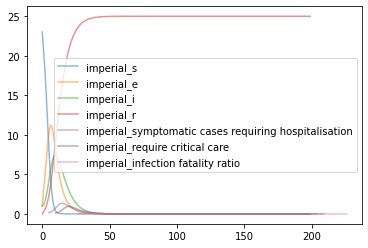

In [31]:
test_df = oa_seir_dfs['E00158888']['80+']
# plot

fig = plt.figure()
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(test_df.index, test_df.iloc[:,0], alpha=0.5, label="imperial_s")
ax.plot(test_df.index, test_df.iloc[:,1], alpha=0.5, label="imperial_e")
ax.plot(test_df.index, test_df.iloc[:,2], alpha=0.5, label="imperial_i")
ax.plot(test_df.index, test_df.iloc[:,3], alpha=0.5, label="imperial_r")
ax.plot(test_df.index + 5, test_df.iloc[:,4], alpha=0.5, label="imperial_symptomatic cases requiring hospitalisation")
ax.plot(test_df.index + 10, test_df.iloc[:,5], alpha=0.5, label='imperial_require critical care')
ax.plot(test_df.index + 27, test_df.iloc[:,6], alpha=0.5, label='imperial_infection fatality ratio')
legend = ax.legend()
plt.show()

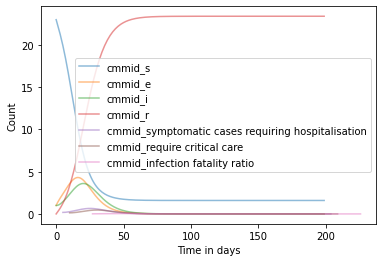

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(test_df.index, test_df.iloc[:,7], alpha=0.5, label="cmmid_s")
ax.plot(test_df.index, test_df.iloc[:,8], alpha=0.5, label="cmmid_e")
ax.plot(test_df.index, test_df.iloc[:,9], alpha=0.5, label="cmmid_i")
ax.plot(test_df.index, test_df.iloc[:,10], alpha=0.5, label="cmmid_r")
ax.plot(test_df.index + 5, test_df.iloc[:,11], alpha=0.5, label="cmmid_symptomatic cases requiring hospitalisation")
ax.plot(test_df.index + 10, test_df.iloc[:,12], alpha=0.5, label='cmmid_require critical care')
ax.plot(test_df.index + 27, test_df.iloc[:,13], alpha=0.5, label='cmmid_infection fatality ratio')
ax.set_xlabel('Time in days')
ax.set_ylabel('Count')

legend = ax.legend()
plt.show()

# Spatial Autocorrelation 

- Merge the oa_df and then the summarised data.

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2832 entries, 0 to 2831
Data columns (total 49 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   oa_code                         2832 non-null   object  
 1   oa_long_lat_text                2832 non-null   geometry
 2   local_authority_code            2832 non-null   object  
 3   lsoa_code                       2832 non-null   object  
 4   lsoa_name                       2832 non-null   object  
 5   lsoa_local_name                 1818 non-null   object  
 6   lsoa_area                       2832 non-null   float64 
 7   lsoa_lengths                    2832 non-null   float64 
 8   lsoa_geom                       2832 non-null   object  
 9   lsoa_long_lat_geom              2832 non-null   object  
 10  lsoa_long_lat_text              2832 non-null   object  
 11  ccg_id                          2832 non-null   object  
 12  ccg_name            

In [34]:
df = df.merge(oa_seir_summed_df, how='left', left_on='oa_code', right_on='oa_code')


In [35]:
print([df.columns[x] for x in range(len(df.columns))])

['oa_code', 'oa_long_lat_text', 'local_authority_code', 'lsoa_code', 'lsoa_name', 'lsoa_local_name', 'lsoa_area', 'lsoa_lengths', 'lsoa_geom', 'lsoa_long_lat_geom', 'lsoa_long_lat_text', 'ccg_id', 'ccg_name', 'ccg_hq_location', 'ccg_geom', 'ccg_long_lat_geom', 'ccg_long_lat_text', 'district_borough_name', 'district_borough_code', 'district_borough_geom', 'district_borough_long_lat_geom', 'district_borough_long_lat_text', 'jsna_id', 'jsna_name', 'jsna_geom', 'jsna_long_lat_geom', 'jsna_long_lat_text', 'msoa_code', 'msoa_name', 'msoa_geom', 'msoa_long_lat_geom', 'msoa_long_lat_text', 'ward_code', 'ward_name', 'ward_geom', 'ward_long_lat_geom', 'ward_long_lat_text', 'all_ages', '0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80+', 'oa_area', 'oa_length', '0-9_scrh_imperial_2.4_sum', '0-9_hcrcc_imperial_2.4_sum', '0-9_ifr_imperial_2.4_sum', '0-9_scrh_cmmid_0.62_sum', '0-9_hcrcc_cmmid_0.62_sum', '0-9_ifr_cmmid_0.62_sum', '10-19_scrh_imperial_2.4_sum', '10-19_hcrcc_imp

In [48]:
df = gpd.GeoDataFrame(df, geometry='oa_long_lat_text')

In [49]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 2832 entries, E00048757 to E00049104
Columns: 104 entries, oa_code to all_ages_scrh_imperial_2.4_sum
dtypes: float64(59), geometry(1), int64(10), object(34)
memory usage: 2.3+ MB


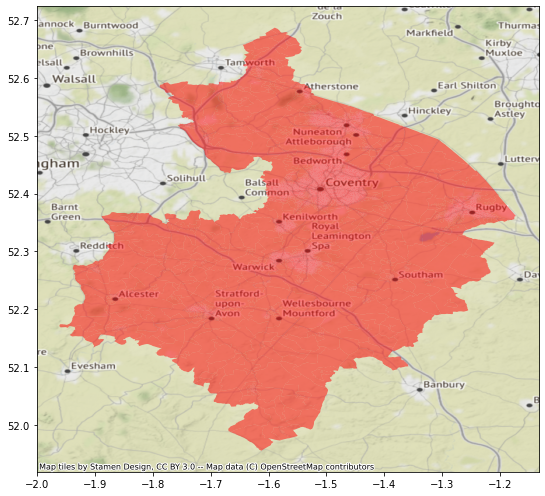

In [50]:
df = df.set_index('oa_code', drop=False)
ax = df.plot(figsize=(9, 9), alpha=0.5, color='red')
ctx.add_basemap(ax, crs=4326)

In [51]:
df.head()

,oa_code,oa_long_lat_text,local_authority_code,lsoa_code,lsoa_name,lsoa_local_name,lsoa_area,lsoa_lengths,lsoa_geom,lsoa_long_lat_geom,...,70-79_scrh_cmmid_0.62_sum,70-79_hcrcc_cmmid_0.62_sum,70-79_ifr_cmmid_0.62_sum,80+_scrh_imperial_2.4_sum,80+_hcrcc_imperial_2.4_sum,80+_ifr_imperial_2.4_sum,80+_scrh_cmmid_0.62_sum,80+_hcrcc_cmmid_0.62_sum,80+_ifr_cmmid_0.62_sum,all_ages_scrh_imperial_2.4_sum
oa_code,,,,,,,,,,,,,,,,,,,,,
E00048757,E00048757,"POLYGON ((-1.49253 52.41265, -1.49247 52.41256...",E08000026,E01009641,Coventry 024F,None,294595.045964,3178.070104,0103000020346C000001000000B3010000E04F8D973E84...,0103000020E610000001000000B3010000888B68C873EB...,...,8.391291,3.625038,0.184877,1.739783,1.233506,0.114716,1.739783,1.233506,0.114716,92.124927
E00048783,E00048783,"POLYGON ((-1.49430 52.41268, -1.49445 52.41272...",E08000026,E01009641,Coventry 024F,None,294595.045964,3178.070104,0103000020346C000001000000B3010000E04F8D973E84...,0103000020E610000001000000B3010000888B68C873EB...,...,6.342856,2.740114,0.139746,5.038401,3.572226,0.332217,4.822874,3.419417,0.318006,106.974912
E00048784,E00048784,"POLYGON ((-1.49430 52.41268, -1.49421 52.41262...",E08000026,E01009641,Coventry 024F,None,294595.045964,3178.070104,0103000020346C000001000000B3010000E04F8D973E84...,0103000020E610000001000000B3010000888B68C873EB...,...,16.580814,7.162912,0.365308,8.337085,5.910994,0.549722,7.893155,5.596247,0.520451,104.280394
E00172182,E00172182,"POLYGON ((-1.49819 52.41216, -1.49817 52.41214...",E08000026,E01009641,Coventry 024F,None,294595.045964,3178.070104,0103000020346C000001000000B3010000E04F8D973E84...,0103000020E610000001000000B3010000888B68C873EB...,...,3.608812,1.559007,0.079509,0.915414,0.649028,0.060360,0.956407,0.678092,0.063063,129.456218
E00172183,E00172183,"POLYGON ((-1.49710 52.41119, -1.49711 52.41116...",E08000026,E01009641,Coventry 024F,None,294595.045964,3178.070104,0103000020346C000001000000B3010000E04F8D973E84...,0103000020E610000001000000B3010000888B68C873EB...,...,4.292888,1.854527,0.094581,0.915414,0.649028,0.060360,0.956407,0.678092,0.063063,51.761969


In [52]:
df2 = df.filter(regex='scrh_imperial')
df2.head()

,0-9_scrh_imperial_2.4_sum,10-19_scrh_imperial_2.4_sum,20-29_scrh_imperial_2.4_sum,30-39_scrh_imperial_2.4_sum,40-49_scrh_imperial_2.4_sum,50-59_scrh_imperial_2.4_sum,60-69_scrh_imperial_2.4_sum,70-79_scrh_imperial_2.4_sum,80+_scrh_imperial_2.4_sum,all_ages_scrh_imperial_2.4_sum
oa_code,,,,,,,,,,
E00048757,0.096996,0.834726,8.305053,5.907141,6.825042,5.888025,7.576679,8.889018,1.739783,92.124927
E00048783,0.205744,1.006910,6.818834,5.617147,6.825042,10.201688,11.086817,6.686874,5.038401,106.974912
E00048784,0.121162,0.499421,2.867665,3.200529,3.716668,7.120500,8.579575,17.697592,8.337085,104.280394
E00172182,0.069809,3.489984,33.135795,5.133823,4.308739,8.352975,5.570885,3.750684,0.915414,129.456218
E00172183,0.087933,0.327237,3.918893,3.297194,2.236489,4.039312,6.573782,4.484731,0.915414,51.761969


In [53]:
## Demo summing all ages to get an overall symtomatic cases requiring hospitalisation.
df['all_ages_scrh_imperial_2.4_sum'] = df.filter(regex='scrh_imperial').sum(axis=1)
df.head()

,oa_code,oa_long_lat_text,local_authority_code,lsoa_code,lsoa_name,lsoa_local_name,lsoa_area,lsoa_lengths,lsoa_geom,lsoa_long_lat_geom,...,70-79_scrh_cmmid_0.62_sum,70-79_hcrcc_cmmid_0.62_sum,70-79_ifr_cmmid_0.62_sum,80+_scrh_imperial_2.4_sum,80+_hcrcc_imperial_2.4_sum,80+_ifr_imperial_2.4_sum,80+_scrh_cmmid_0.62_sum,80+_hcrcc_cmmid_0.62_sum,80+_ifr_cmmid_0.62_sum,all_ages_scrh_imperial_2.4_sum
oa_code,,,,,,,,,,,,,,,,,,,,,
E00048757,E00048757,"POLYGON ((-1.49253 52.41265, -1.49247 52.41256...",E08000026,E01009641,Coventry 024F,None,294595.045964,3178.070104,0103000020346C000001000000B3010000E04F8D973E84...,0103000020E610000001000000B3010000888B68C873EB...,...,8.391291,3.625038,0.184877,1.739783,1.233506,0.114716,1.739783,1.233506,0.114716,138.187390
E00048783,E00048783,"POLYGON ((-1.49430 52.41268, -1.49445 52.41272...",E08000026,E01009641,Coventry 024F,None,294595.045964,3178.070104,0103000020346C000001000000B3010000E04F8D973E84...,0103000020E610000001000000B3010000888B68C873EB...,...,6.342856,2.740114,0.139746,5.038401,3.572226,0.332217,4.822874,3.419417,0.318006,160.462368
E00048784,E00048784,"POLYGON ((-1.49430 52.41268, -1.49421 52.41262...",E08000026,E01009641,Coventry 024F,None,294595.045964,3178.070104,0103000020346C000001000000B3010000E04F8D973E84...,0103000020E610000001000000B3010000888B68C873EB...,...,16.580814,7.162912,0.365308,8.337085,5.910994,0.549722,7.893155,5.596247,0.520451,156.420591
E00172182,E00172182,"POLYGON ((-1.49819 52.41216, -1.49817 52.41214...",E08000026,E01009641,Coventry 024F,None,294595.045964,3178.070104,0103000020346C000001000000B3010000E04F8D973E84...,0103000020E610000001000000B3010000888B68C873EB...,...,3.608812,1.559007,0.079509,0.915414,0.649028,0.060360,0.956407,0.678092,0.063063,194.184327
E00172183,E00172183,"POLYGON ((-1.49710 52.41119, -1.49711 52.41116...",E08000026,E01009641,Coventry 024F,None,294595.045964,3178.070104,0103000020346C000001000000B3010000E04F8D973E84...,0103000020E610000001000000B3010000888B68C873EB...,...,4.292888,1.854527,0.094581,0.915414,0.649028,0.060360,0.956407,0.678092,0.063063,77.642953


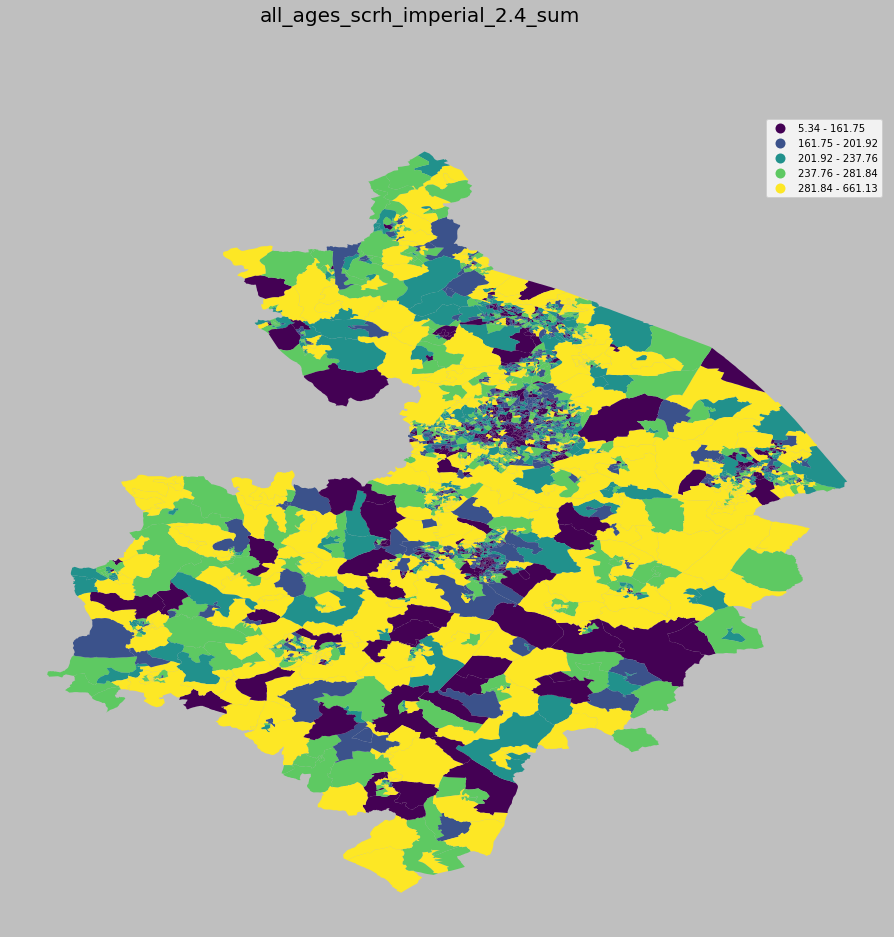

In [54]:
f, ax = plt.subplots(1, figsize=(30, 15))
df.plot(column='all_ages_scrh_imperial_2.4_sum', scheme='Quantiles', legend=True, ax=ax)
# Remove axis frame
ax.set_axis_off()
# change background colour of the figure
f.set_facecolor('0.75')
# Title
f.suptitle('all_ages_scrh_imperial_2.4_sum', size=20)
plt.show()

In [56]:
%time w = weights.Queen.from_dataframe(df, idVariable='oa_code', geom_col='oa_long_lat_text')

CPU times: user 6.91 s, sys: 2.69 s, total: 9.59 s
Wall time: 17.6 s


In [57]:
w['E00048204']

{'E00048225': 1.0, 'E00048219': 1.0, 'E00048221': 1.0, 'E00048216': 1.0}

In [58]:
# Row standardise the matrix the row adds up to 1.
w.transform = 'R'

In [59]:
w['E00048204']

{'E00048225': 0.25, 'E00048219': 0.25, 'E00048221': 0.25, 'E00048216': 0.25}

In [60]:
df['w_all_ages_scrh_imperial_2.4_sum'] = weights.lag_spatial(w, df['all_ages_scrh_imperial_2.4_sum'])

In [61]:
df[['all_ages_scrh_imperial_2.4_sum', 'w_all_ages_scrh_imperial_2.4_sum']].head()

,all_ages_scrh_imperial_2.4_sum,w_all_ages_scrh_imperial_2.4_sum
oa_code,,
E00048757,138.187390,105.676941
E00048783,160.462368,237.390571
E00048784,156.420591,169.647949
E00172182,194.184327,168.334126
E00172183,77.642953,223.570756


In [62]:
w.neighbors['E00048204']

['E00048225', 'E00048219', 'E00048221', 'E00048216']

In [63]:
neis = df.loc[w.neighbors['E00048204'], 'all_ages_scrh_imperial_2.4_sum']
neis

oa_code
E00048225    232.417176
E00048219    177.880162
E00048221    218.352464
E00048216    180.290726
Name: all_ages_scrh_imperial_2.4_sum, dtype: float64

In [65]:
neis.mean()

202.2351321135402

In [67]:
# standardise the numbers
df['all_ages_scrh_imperial_2.4_sum_std'] = (
    df['all_ages_scrh_imperial_2.4_sum'] - df['all_ages_scrh_imperial_2.4_sum'].mean()) / df['all_ages_scrh_imperial_2.4_sum'].std()

In [68]:
df['w_all_ages_scrh_imperial_2.4_sum_std'] = weights.lag_spatial(w, df['all_ages_scrh_imperial_2.4_sum_std'])

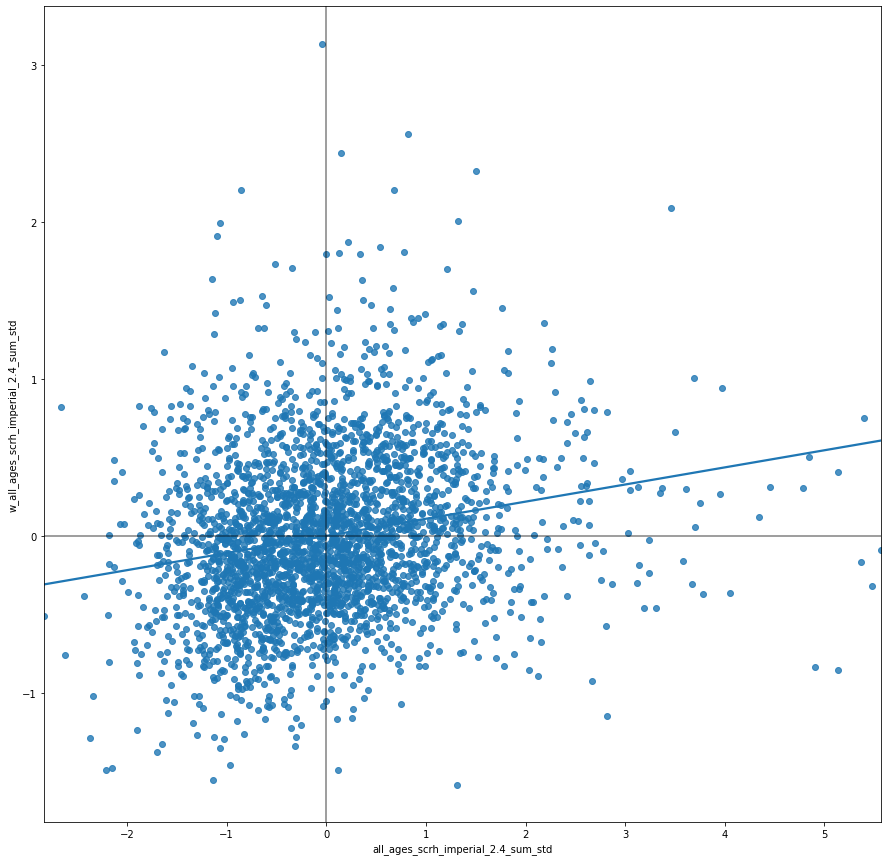

In [69]:
f, ax = plt.subplots(1, figsize=(15,15))
sns.regplot(x='all_ages_scrh_imperial_2.4_sum_std', y='w_all_ages_scrh_imperial_2.4_sum_std', data=df, ci=None)
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
plt.show()

In [70]:
# Global Moran's I
mi = esda.Moran(df['all_ages_scrh_imperial_2.4_sum'], w)

In [71]:
mi.I

0.10910180723527024

In [72]:
mi.p_sim

0.001

(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f50c2f16fd0>)

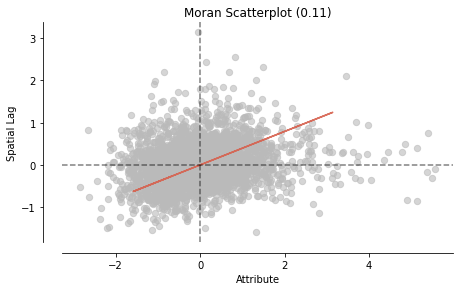

In [73]:
moran_scatterplot(mi)

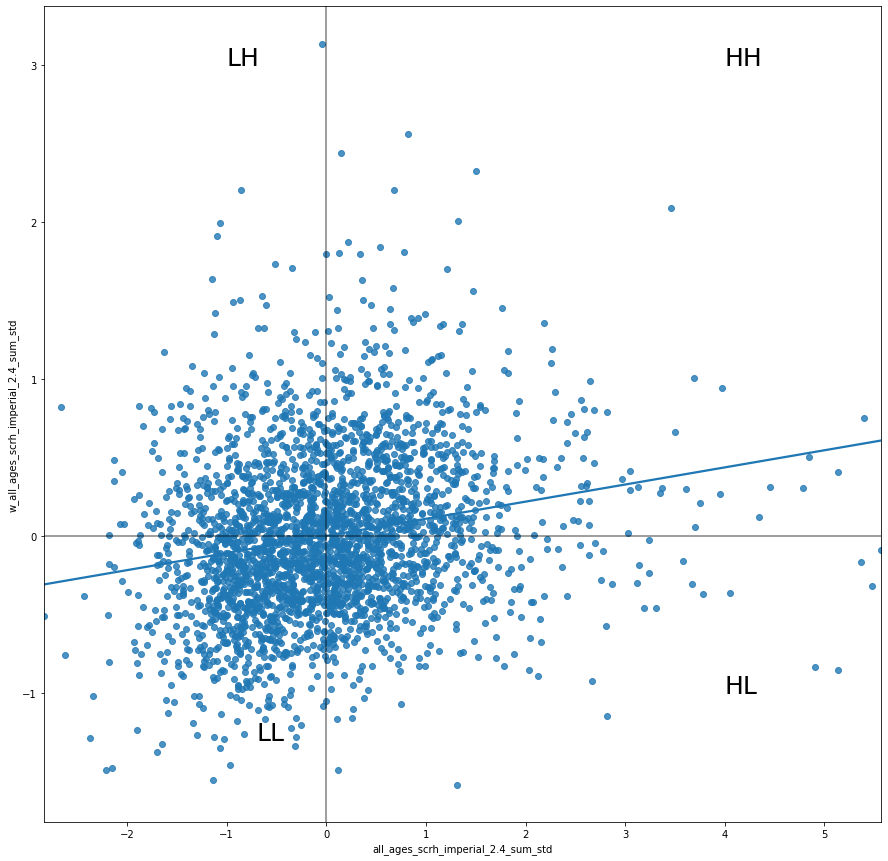

In [75]:
f, ax = plt.subplots(1, figsize=(15,15))
sns.regplot(x='all_ages_scrh_imperial_2.4_sum_std', y='w_all_ages_scrh_imperial_2.4_sum_std', data=df, ci=None)
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
plt.text(4, 3, 'HH', fontsize=25)
plt.text(4, -1, "HL", fontsize=25)
plt.text(-1, 3, "LH", fontsize=25)
plt.text(-.7, -1.3, "LL", fontsize=25)
plt.show()

In [76]:
lisa = esda.Moran_Local(df['all_ages_scrh_imperial_2.4_sum'], w)

In [77]:
df['all_ages_scrh_imperial_2.4_sum_signficant'] = lisa.p_sim < 0.05
df['all_ages_scrh_imperial_2.4_sum_quadrant'] = lisa.q

In [78]:
df['all_ages_scrh_imperial_2.4_sum_signficant'].head()

oa_code
E00048757     True
E00048783    False
E00048784     True
E00172182     True
E00172183    False
Name: all_ages_scrh_imperial_2.4_sum_signficant, dtype: bool

In [79]:
lisa.p_sim[:5]

array([0.001, 0.356, 0.007, 0.029, 0.486])

In [81]:
df['all_ages_scrh_imperial_2.4_sum_quadrant'].head()

oa_code
E00048757    3
E00048783    2
E00048784    3
E00172182    3
E00172183    3
Name: all_ages_scrh_imperial_2.4_sum_quadrant, dtype: int64

## Quadrant for LISA (Local Indicators of Spatial Association)

The below map demonstrates areas that are statistically significant and suggestive evidence of areas in the county that score highly in the category of symptomatic cases requiring hospitalisation (SCRH). In red on the map it shows areas that are unusually high scoring with a 95% confidence interval. Based on the variable, and the contiguious boundaries of the neighbouring populations.

The idea is to idenfity cases in which the comparison between the value of an observation (SCRH) and the average of its neighbours is either more similar(HH, LL) or dissimilar (HL, LH) than we would expect from pure chance.

This returns values which identify clusters of values in space and are concentrated. The purpose to simplify what might be a complicated picture.

* Quadrant 1 = HH (High values surrounded by High values)
* Quadrant 2 = LH (Low values surrounded by High values)
* Quadrant 3 = LL (Low values surrounded by Low values)
* Quadrant 4 = HL (High values surrounding by Low values)

(<Figure size 2160x1080 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f50c2f597b8>)

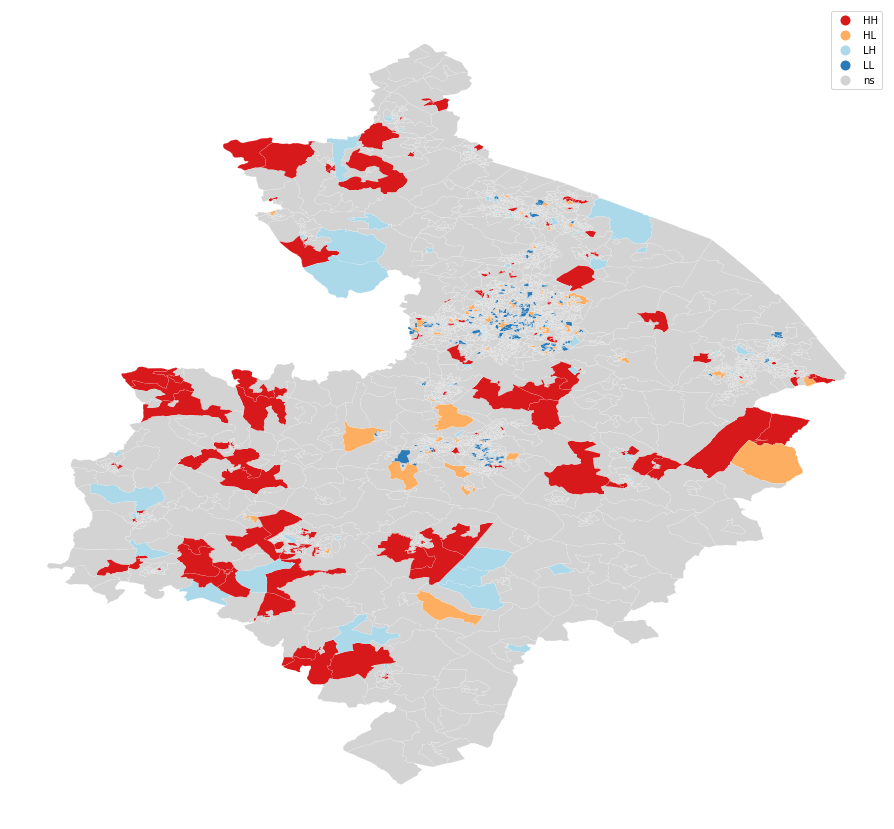

In [82]:
lisa_cluster(lisa, df, figsize=(30,15))